In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-f80e9374-504a-571b-bac0-6fb00750db4c"

In [2]:
import sys
sys.path.append('../2_train_models')

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

#from data_loading import read_fasta_fast, one_hot_encode

cell_type = "K562"
timestamp = "2022-10-05_03-39-32"
model_type = "strand_merged_umap"
data_type = "procap"

from file_configs import ValFilesConfig

In [4]:
val_config = ValFilesConfig(cell_type, model_type, timestamp, data_type)
in_window = val_config.in_window
out_window = val_config.out_window

Timestamp: 2022-10-05_03-39-32


In [5]:
import pyBigWig
from data_loading import read_fasta_fast, one_hot_encode

def load_sequence_at_locus(chrom, start, end, genome_path):
    genome = read_fasta_fast(genome_path, include_chroms = [chrom])
    seq = genome[chrom][start:end]
    onehot_seq = one_hot_encode(seq).T
    return seq, onehot_seq


def load_observed_profile_at_locus(chrom, start, end, plus_bw_path, minus_bw_path):
    with pyBigWig.open(plus_bw_path, "r") as plus_bw:
        plus_sig = plus_bw.values(chrom, start, end, numpy=True)
    plus_sig = np.nan_to_num(plus_sig)

    with pyBigWig.open(minus_bw_path, "r") as minus_bw:
        minus_sig = minus_bw.values(chrom, start, end, numpy=True)
    minus_sig = np.nan_to_num(minus_sig)

    signal = np.array([plus_sig, minus_sig])
    return signal


def get_locus_data(chrom, start, end, val_config):
    in_window = val_config.in_window
    out_window = val_config.out_window
    genome_path = val_config.genome_path
    plus_bw_path = val_config.plus_bw_path
    minus_bw_path = val_config.minus_bw_path
    
    mid = (start + end) // 2
    seq_start = mid - in_window // 2
    seq_end = seq_start + in_window
    seq, onehot_seq = load_sequence_at_locus(chrom, seq_start, seq_end, genome_path)
    
    prof_start = mid - out_window // 2
    prof_end = prof_start + out_window
    prof = load_observed_profile_at_locus(chrom, prof_start, prof_end, plus_bw_path, minus_bw_path)
    
    return seq, onehot_seq, prof


# MYC promoter
chrom, start, end = ["chr8", 127735880, 127736479]
sup_title = "MYC Promoter, " + chrom + ":" + str(start) + "-" + str(end)

val_config = ValFilesConfig(cell_type, model_type, timestamp, data_type)
og_seq, og_onehot_seq, og_prof = get_locus_data(chrom, start, end, val_config)

Timestamp: 2022-10-05_03-39-32
Loading genome sequence from /mnt/lab_data2/kcochran/new_procap_models/genomes/hg38.withrDNA.fasta


Reading FASTA: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.84s/it]


In [6]:
def load_model(val_config):
    model = torch.load(val_config.model_save_path)
    model.eval()
    model = model.cuda()
    return model

model = load_model(val_config)

In [7]:
def predict(onehot_seq, model):
    with torch.no_grad():
        onehot_seq = torch.tensor(onehot_seq, dtype=torch.float32)[None,...].cuda()
        pred_profs, pred_logcounts = model.predict(onehot_seq)

    pred_prof = np.exp(pred_profs.squeeze())
    pred_counts = pred_logcounts.squeeze()
    pred_prof = pred_prof * pred_counts
    return pred_prof

og_pred_prof = predict(og_onehot_seq, model)

In [8]:
sys.path.append('../4_interpret_models')

from deepshap_utils import get_attributions, ProfileModelWrapper, CountsModelWrapper
from captum.attr import DeepLiftShap

prof_shap_explainer = DeepLiftShap(ProfileModelWrapper(model))
count_shap_explainer = DeepLiftShap(CountsModelWrapper(model))

def deepshap(seq):
    if type(seq) == str:
        seq = one_hot_encode(seq).T
    if len(seq.shape) < 3:
        seq = seq[None,...]
    
    prof_attr, _ = get_attributions(seq, prof_shap_explainer, count_shap_explainer)
    prof_attr = prof_attr * seq
    return prof_attr.squeeze()

og_prof_attr = deepshap(og_onehot_seq)

  0%|                                                                                                                                                                                                                                   | 0/1 [00:00<?, ?it/s]/users/kcochran/miniconda3/envs/procap_A100/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.32s/it]


In [22]:
mutate_positions = [522, 550, 550, 362, 504, 441, 439, 494]
mutate_seqs = ["GGGG", "GG", "CGGCA", "CGGC", "CTAGCTA", "CC", "A", "AGTG"]
mutate_labels = ["Right TATA\nAblated",
                 "Right Inr\nAblated",
                 "Right Inr\nAblated # 2",
                 "Left TATA\nAblated",
                 "BRE\nAblated",
                 "Left Inr\nAblated",
                 "Left Inr\nImproved",
                 "Added Inr\n-30 from TATA"]

mutate_positions = [522, 550, 362, 504, 439]
mutate_seqs = ["GGGG", "GG", "CGGC", "CTAGCTA", "A"]
mutate_labels = ["Right TATA\nAblated",
                 "Major Inr\nAblated",
                 "Left TATA\nAblated",
                 "BRE\nAblated",
                 "Minor Inr\nStrengthened"]


assert len(mutate_positions) == len(mutate_seqs)
assert len(mutate_seqs) == len(mutate_labels)

In [19]:
def get_mutated_prof_preds_and_attrs(og_onehot_seq, mutate_positions, mutate_seqs):
    pred_profs = []
    attrs = []
    for mutate_pos, mutate_to in zip(mutate_positions, mutate_seqs):
            mutate_pos = mutate_pos + (in_window - out_window) // 2
            new_seq_onehot = [og_onehot_seq[:, :mutate_pos]]
            new_seq_onehot += [one_hot_encode(mutate_to).T]
            new_seq_onehot += [og_onehot_seq[:, mutate_pos + len(mutate_to):]]
            new_seq_onehot = np.concatenate(new_seq_onehot, axis=-1)

            pred_prof = predict(new_seq_onehot, model)
            pred_profs.append(pred_prof)
            
            attr = deepshap(new_seq_onehot)
            attrs.append(attr)
        
    return pred_profs, attrs

mutate_pred_profs, mutate_attrs = get_mutated_prof_preds_and_attrs(og_onehot_seq,
                                                                   mutate_positions,
                                                                   mutate_seqs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


In [20]:
import viz_sequence

def slice_to_prof_len(attrs, prof_len = out_window):
    assert attrs.shape[-1] >= prof_len, attrs.shape
    mid = attrs.shape[-1] / 2
    prof_start = int(mid - prof_len / 2)
    prof_end = int(mid + prof_len / 2)
    return attrs[..., prof_start : prof_end ]


def plot_prof_on_ax(profile, ax, zoom_start, zoom_end, label,
                    colors = ["#480CA8", "#480CA8"], alphas = [0.8, 0.5],
                    linewidth=1.5, x_axis_buffer=0, axis_fontsize=8, labelpad=10):
    
    x_range = np.arange(zoom_start, zoom_end)
    ax.plot(x_range, profile[0, zoom_start:zoom_end],
            alpha = alphas[0], c = colors[0], linewidth=linewidth)
    ax.plot(x_range, -1 * profile[1, zoom_start:zoom_end],
            alpha = alphas[1], c = colors[1], linewidth=linewidth)

    ax.set_xlim(zoom_start - x_axis_buffer, zoom_end + x_axis_buffer)
    
    if label is not None:
        ax.set_ylabel(label, fontsize = axis_fontsize, rotation=90, labelpad=labelpad)

    
def plot_attrs_on_ax(attr, ax, zoom_start, zoom_end, label,
                     axis_fontsize=8, labelpad=10):
    
    attr = slice_to_prof_len(attr)
    viz_sequence.plot_weights_given_ax(ax=ax,
                                       array=attr[:, zoom_start : zoom_end],
                                       height_padding_factor=0,
                                       length_padding=1.0,
                                       subticks_frequency=50,
                                       highlight={})
    if label is not None:
        ax.set_ylabel(label, fontsize = axis_fontsize, rotation=90, labelpad=labelpad)
    
    
def get_prof_plot_lims(profs, zoom_start, zoom_end):
    neg_max_so_far = 0
    max_so_far = 0
    for prof in profs:
        max_so_far = max(max_so_far, np.max(prof[0, zoom_start:zoom_end]))
        neg_max_so_far = max(neg_max_so_far, np.max(prof[1, zoom_start:zoom_end]))
    return -1 * neg_max_so_far, max_so_far 

def get_attr_plot_lims(attrs, zoom_start, zoom_end):
    neg_max_so_far = 0
    max_so_far = 0
    for attr in attrs:
        attr = slice_to_prof_len(attr)
        max_so_far = max(max_so_far, np.max(attr[:, zoom_start:zoom_end]))
        neg_max_so_far = min(neg_max_so_far, np.min(attr[:, zoom_start:zoom_end]))
    return neg_max_so_far, max_so_far 

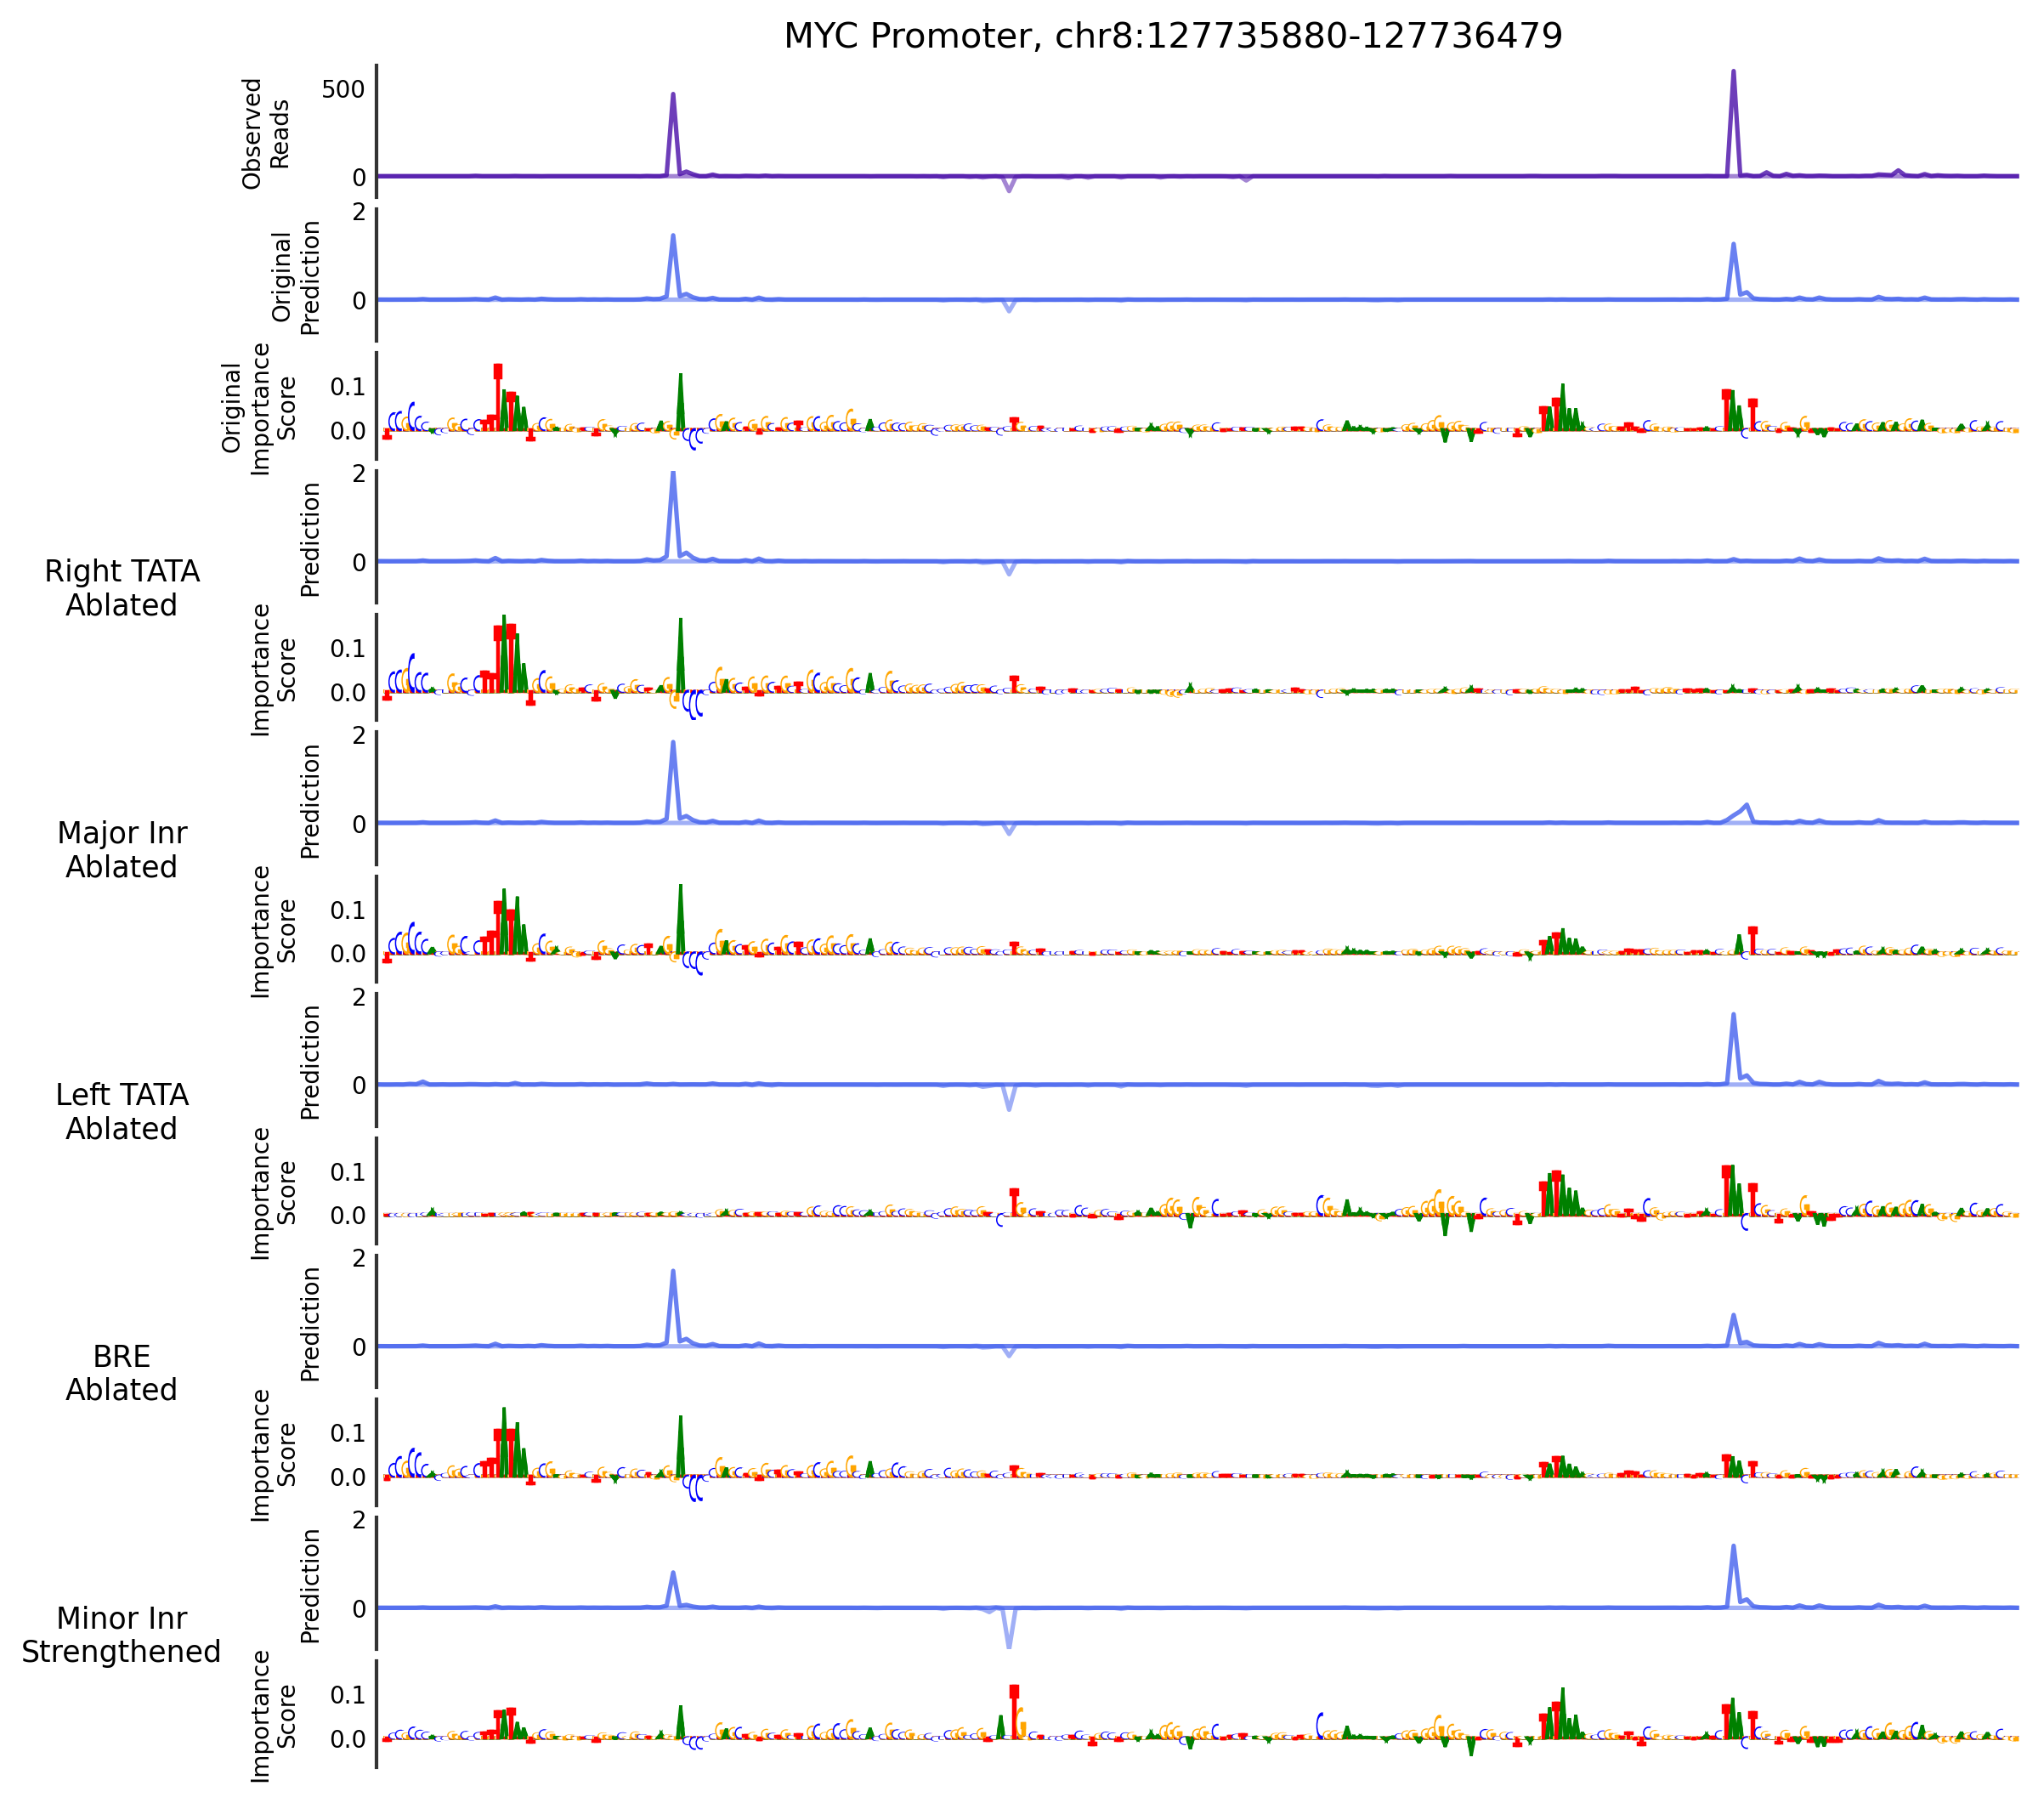

In [25]:
def plot_mutate_effect_with_attrs(og_seq, og_onehot_seq,
                                  true_profile, og_pred_profile, og_prof_attr,
                                  mutate_pred_profs, mutate_attrs, mutate_labels,
                                  prof_len = out_window, title = sup_title,
                                  zoom_midpoint = 470, zoom_width = 250):
    
    assert len(mutate_pred_profs) == len(mutate_attrs), (len(mutate_pred_profs), len(mutate_attrs))
    
    plot_params = {"xtick.labelsize": 8, "ytick.labelsize": 8}
    plt.rcParams.update(plot_params)
    
    num_subplots = 3 + 2 * len(mutate_positions)

    fig = plt.figure(figsize=(10, 0.8 * num_subplots), dpi=250)
    gs = fig.add_gridspec(num_subplots, hspace=0.1,
                          height_ratios = [10,10,8] + [10,8] * len(mutate_positions))
    axes = gs.subplots()

    if title is not None:
        fig.suptitle(title, y = 0.9, fontsize=12, horizontalalignment='center')#, x = 0.12)
    
    zoom_start = min(max(zoom_midpoint - zoom_width//2, 0), prof_len - zoom_width)
    zoom_end = zoom_start + zoom_width
    
    pred_prof_min, pred_prof_max = get_prof_plot_lims([og_pred_profile] + mutate_pred_profs,
                                                      zoom_start, zoom_end)
    attr_min, attr_max = get_attr_plot_lims([og_prof_attr] + mutate_attrs,
                                            zoom_start, zoom_end)
    
    axis_index = 0
        
    plot_prof_on_ax(true_profile, axes[axis_index], zoom_start, zoom_end,
                    "Observed\nReads",
                    colors = ["#480CA8", "#480CA8"], alphas = [0.8, 0.5])

    axis_index += 1
    
    plot_prof_on_ax(og_pred_profile, axes[axis_index], zoom_start, zoom_end,
                    "Original\nPrediction",
                    colors = ["#4361EE", "#4361EE"], alphas = [0.8, 0.5])
    axes[axis_index].set_ylim(pred_prof_min, pred_prof_max)
    axis_index += 1
    
    plot_attrs_on_ax(og_prof_attr, axes[axis_index], zoom_start, zoom_end,
                     "Original\nImportance\nScore")
    axes[axis_index].set_ylim(attr_min, attr_max)
    
    
    for mutate_prof, mutate_attr, label in zip(mutate_pred_profs, mutate_attrs, mutate_labels):
        axis_index += 1
        plot_prof_on_ax(mutate_prof, axes[axis_index], zoom_start, zoom_end, "Prediction",
                    colors = ["#4361EE", "#4361EE"], alphas = [0.8, 0.5])
        axes[axis_index].set_ylim(pred_prof_min, pred_prof_max)
        
        axis_index += 1
        plot_attrs_on_ax(mutate_attr, axes[axis_index], zoom_start, zoom_end, "Importance\nScore")
        axes[axis_index].set_ylim(attr_min, attr_max)
        
        axes[axis_index].text(-40, attr_max, label, ha="center")
    
    curr_xticks = axes[axis_index].get_xticks()
    axes[axis_index].set_xticks(curr_xticks, [int(tick_pos + zoom_start) for tick_pos in curr_xticks])
    
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        #ax.yaxis.set_label_coords(-0.1,0.25)
        ax.tick_params(left=False, length=0)
        
        ax.spines["left"].set_linewidth(1.2)
        ax.spines["bottom"].set_linewidth(1.2)
        ax.spines["left"].set_color("#333333")
        ax.spines["bottom"].set_color("#333333")
    
        
    for ax in axes:
        ax.spines['bottom'].set_visible(False)
        ax.set_xticks([])
    
    plt.show()
    
plot_mutate_effect_with_attrs(og_seq, og_onehot_seq,
                              og_prof, og_pred_prof, og_prof_attr,
                              mutate_pred_profs, mutate_attrs, mutate_labels,
                              prof_len = out_window, title = sup_title)

In [ ]:
ablate_and_see_effect(og_seq, obs_prof, og_pred_prof, model, 550, "TTAACT",
                      title = "MYC: Right Alt-Inr Moved Right 1bp")
ablate_and_see_effect(og_seq, obs_prof, og_pred_prof, model, 550, "GTTAACT",
                      title = "MYC: Right Alt-Inr Moved Right 2bp")
ablate_and_see_effect(og_seq, obs_prof, og_pred_prof, model, 550, "CGTTAACT",
                      title = "MYC: Right Alt-Inr Moved Right 3bp")
ablate_and_see_effect(og_seq, obs_prof, og_pred_prof, model, 550, "ACGTTAACT",
                      title = "MYC: Right Alt-Inr Moved Right 4bp")
ablate_and_see_effect(og_seq, obs_prof, og_pred_prof, model, 550, "GACGTTAACT",
                      title = "MYC: Right Alt-Inr Moved Right 5bp")


ablate_and_see_effect(og_seq, obs_prof, og_pred_prof, model, 504, "CCGGGAGGG",
                      title = "MYC: BRE Moved Right 2bp")
ablate_and_see_effect(og_seq, obs_prof, og_pred_prof, model, 504, "CGCCGGGAGGG",
                      title = "MYC: BRE Moved Right 4bp")
ablate_and_see_effect(og_seq, obs_prof, og_pred_prof, model, 502, "GGGAGGGCG",
                      title = "MYC: BRE Moved Left 2bp")
ablate_and_see_effect(og_seq, obs_prof, og_pred_prof, model, 500, "GGGAGGGCGCC",
                      title = "MYC: BRE Moved Left 4bp")